# Autogen Agents with Azure Cognitive Search, Azure Bing Search 

This notebook demonstrates the use of AI AutoGen Agents with tools which use Azure Cognitive Search and Bing Search to extract data.This notebook uses multi-agent communication and also switches between the agents based on the customer ask


## Login to Azure:
   

In [ ]:
# Check Azure CLI installation and login status
#!az --version
#!az login

## Install required packages
Run the cell below to install the required packages for this notebook.



In [1]:

%pip install python-dotenv --quiet
%pip install pyautogen --quiet
%pip install azure-search-documents --quiet
%pip install azure-identity --quiet
%pip install python-dotenv --quiet
%pip install typing-extensions==4.7 --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-dataprep 5.1.6 requires cloudpickle<3.0.0,>=1.1.0, but you have cloudpickle 3.0.0 which is incompatible.
azureml-mlflow 1.56.0 requires azure-storage-blob<=12.19.0,>=12.5.0, but you have azure-storage-blob 12.20.0 which is incompatible.
pydantic-core 2.18.4 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Import the required packages for this notebook.



In [1]:
import json
import os

import requests
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from dotenv import load_dotenv
from azure.search.documents.indexes.models import SemanticConfiguration 
import autogen
from autogen import AssistantAgent, UserProxyAgent, register_function
from autogen.cache import Cache
from autogen.graph_utils import visualize_speaker_transitions_dict



Load the parameters from the azure.env file 

In [2]:
import os
from pathlib import Path
dotenv_path = Path('azure.env')
load_dotenv(dotenv_path=dotenv_path)

# Import Cognitive Search index ENV
AZURE_SEARCH_SERVICE = os.getenv("AZURE_SEARCH_SERVICE")
AZURE_SEARCH_INDEX = os.getenv("AZURE_SEARCH_INDEX")
AZURE_SEARCH_KEY = os.getenv("AZURE_SEARCH_KEY")
AZURE_SEARCH_API_VERSION = os.getenv("AZURE_SEARCH_API_VERSION")
AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG = os.getenv("AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG")
AZURE_SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
bing_search_subscription_key = os.getenv('BING_SUBSCRIPTION_KEY')
bing_search_url = "https://api.bing.microsoft.com/v7.0/search"

7eb539fcfa35406aa73fd0d15e163ddd


Azure AI Search function will search customer enterprise data source which is the imported index, and "semantic-configuration" which is created on the index to enable semantic search. This search function will handle the customer enterprise data scenario  and will be called when prompt requires LLM to call enterprise data which is differentiated by "hotel" asks

In [3]:

def search(query: str):
    results =  client.search(query_type='semantic',
    search_text=query ,
    select=["HotelName","Rooms/Description", "Address"],
    semantic_configuration_name= AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG,
    top=4,
    include_total_count=True)
    output=[]
    for result in results:
        output.append(result)

        
    return output


Create a Search function using Azure Bing search API(s), this function will be used by the AI Agents when the requested data is not present in the enterprise AI Search function


**Note: **If you want to access other data sources to just want to test the flow of agents, you can update the data source to your enterprise data source or can return any string message

In [4]:
def search_bing(query:str):
    headers = {"Ocp-Apim-Subscription-Key": bing_search_subscription_key}
    params = {"q": query, "textDecorations": False }
    response = requests.get(bing_search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()

    output = []

    for result in search_results['webPages']['value']:
        output.append({
            'title': result['name'],
            'link': result['url'],
            'snippet': result['snippet']
        })

    return json.dumps(output)

Create an Azure AI search client to access the created AI search service and index 

In [5]:
from azure.core.credentials import AzureKeyCredential
credential = AzureKeyCredential(AZURE_SEARCH_KEY)
endpoint = AZURE_SEARCH_SERVICE_ENDPOINT
client = SearchClient(endpoint=endpoint, index_name=AZURE_SEARCH_INDEX, credential=credential)
#print(search("""waterfront hotels"""))

Load the configuration list and define the configuration for the `AssistantAgent`from OAI_CONFIG_LIST

In [15]:
config_list= autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt4-0125"],
    },
)

gpt4_config = {
    "cache_seed": None,
    "temperature": 0,
    "config_list": config_list,
    "timeout": 120,
}
print(config_list)

[{'model': 'gpt4-0125', 'api_key': '7eb539fcfa35406aa73fd0d15e163ddd', 'base_url': 'https://openainsresouirce.openai.azure.com/', 'api_type': 'azure', 'api_version': '2024-02-01'}]



Define three Agents COGSearch,BINGsearch and Summarizationagent , these agents will work together to generate the desired output

In [16]:
cog_search = AssistantAgent(
    name="COGSearch",
    system_message="You are a helpful hotels search AI assistant to search hotels. "
    "You can help with Azure AI Search index based search."
    "Return 'TERMINATE' when the task is done.",
    llm_config=gpt4_config,
    description="""
    "Search from Azure AI Search for hotels information """
)



bing_search = AssistantAgent(
    name="BINGsearch",
    system_message="You are a helpful AI assistant to find web results from bing search."
    "You can help with bing Search."
    "Return 'TERMINATE' when the task is done.",
    llm_config=gpt4_config,
     description="""
    "This toolis to Search for latest web based records which do not exist in AI Search index"""
)


summarize_agent = AssistantAgent(
    name="summarizeagent",
    system_message="You are a helpful hotels search AI assistant . "
    "You will summarize the serach results in a bulleted format."
    "Return 'TERMINATE' when the task is done.",
    llm_config=gpt4_config,
    description="""
    Summarize the final answer """
)
user_proxy = UserProxyAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
    system_message="Give the task, and send "
    "instructions to other agents to complete the task.",
)


Register the defined tools (our  functions) with our agents so that our agents can use these tools when required.

**Note** : pay special attention to description filed, as this is the field is seen by other agents to understand the purpose of agents

In [17]:

register_function(
    search,
    caller=cog_search,
    executor=user_proxy,
    name="search",
    description="A tool for searching for hotels information in the {AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG} index ",
)

register_function(
    search_bing,
    caller=bing_search,
    executor=user_proxy,
    name="search_bing",
    description="A tool for bing based search, DO NOT use this tool for hotels related searches"
)

The return type of the function 'search' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.
The return type of the function 'search_bing' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.


Craate a group chat and provide the names of the agents that will communicate with each other  

In [18]:
agents=[user_proxy, cog_search, bing_search,summarize_agent ]

We can also define allowed speakers by providing the transition path in the "allowed_or_disallowed_speaker_transitions" parameter  

In [19]:
allowed_speaker_transitions_dict = {agent: [other_agent for other_agent in agents]
 for agent in agents}



Please view the agents communication and transition paths below

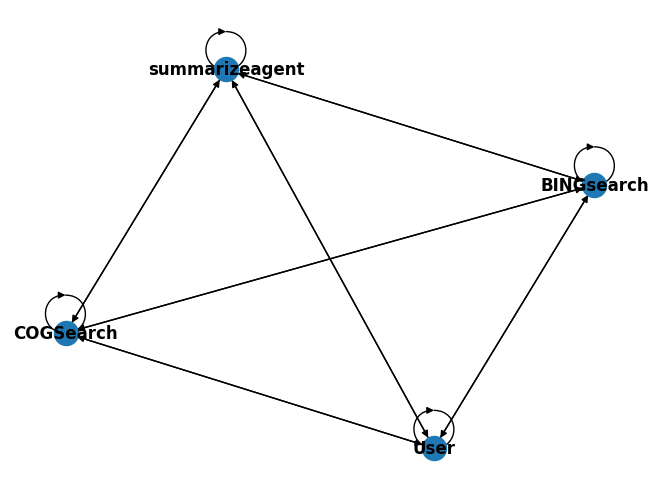

In [20]:
visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

We can pass the agents transition path to "GroupChat" which will govern the transition between agents as per the transitions allowed in "allowed_speaker_transitions_dict" which we defined wbove

In [21]:
groupchat = autogen.GroupChat(
    agents=agents,
    messages=[],
    max_round=4,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed"
)

In [22]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=gpt4_config
)

Initiate the chat to see the below scenarios

- When we ask about hotels, the right agent is activated and brings the result from the AI Search - Please note you can extend this to include your enterprise data sources or SQL data or any other data source. Concept remains same 
- When you ask any question out side the scope of enterprise data ( non hotel question) bing agent is activated to solve the ask
- Notice that at the end both above agents will call the summarize agent to summarize the answer

**Scenario # 1**  - Bing Agent is called, followed by summarizeagent as the ask can not be solved by CogSearch Agent, pay attention to the function called , in below case bing_search function is called which is used by BINGsearch agent 

In [23]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message="Please provide me a  list of top 5 National Parks in USA, please provide a brief highlight of each park main attraction",
   
)

User (to chat_manager):

Please provide me a  list of top 5 National Parks in USA, please provide a brief highlight of each park main attraction

--------------------------------------------------------------------------------

Next speaker: BINGsearch

BINGsearch (to chat_manager):

***** Suggested tool call (call_9JKFJcVCa1jFykwD5nzb85U0): search_bing *****
Arguments: 
{"query":"top 5 National Parks in USA"}
****************************************************************************

--------------------------------------------------------------------------------

Next speaker: User


>>>>>>>> EXECUTING FUNCTION search_bing...
User (to chat_manager):

User (to chat_manager):

***** Response from calling tool (call_9JKFJcVCa1jFykwD5nzb85U0) *****
[{"title": "List of Top 25 Best US National Parks - More Than Just Parks", "link": "https://morethanjustparks.com/national-parks-ranked/", "snippet": "Find out the top 5 national parks in the USA based on accessibility, recreation, crowds, a

[runtime logging] log_function_use: autogen logger is None


**Scenario # 2**  -AI Search agent is called to fetch data from enterprise data source, followed by summarizeagent as the ask can not be solved by in-house dataset 

In [24]:
groupchat_result = user_proxy.initiate_chat(
    manager,
     message="""Please provide me hotels with Waterfront View , summarize the answer by just giving the hotel name and brief overview""",
)

User (to chat_manager):

Please provide me hotels with Waterfront View , summarize the answer by just giving the hotel name and brief overview

--------------------------------------------------------------------------------

Next speaker: COGSearch

COGSearch (to chat_manager):

***** Suggested tool call (call_t6z2RsOaAcV08W5y22hu1RWR): search *****
Arguments: 
{"query":"Waterfront View"}
***********************************************************************

--------------------------------------------------------------------------------

Next speaker: User


>>>>>>>> EXECUTING FUNCTION search...
User (to chat_manager):

User (to chat_manager):

***** Response from calling tool (call_t6z2RsOaAcV08W5y22hu1RWR) *****
[{"Rooms": [{"Description": "Standard Room, 1 Queen Bed (Cityside)"}, {"Description": "Budget Room, 2 Queen Beds (Cityside)"}, {"Description": "Standard Room, 2 Double Beds (Waterfront View)"}, {"Description": "Suite, 1 Queen Bed (Waterfront View)"}, {"Description": "Delu

[runtime logging] log_function_use: autogen logger is None


In previous example we allowed all agents to agents communication, now I am putting a path as per my business rules and use case, please feel free to comment any agent to agent path and execute the "visualize..." code block to see how the agents transitions can be governed.

In [25]:
allowed_speaker_transitions_dict_hub_and_spoke = {
    agents[0]: [agents[1], agents[2],agents[3]],
    #agents[1]: [agents[0]],
    agents[2]: [agents[0]],
    agents[3]: [agents[0]],
}


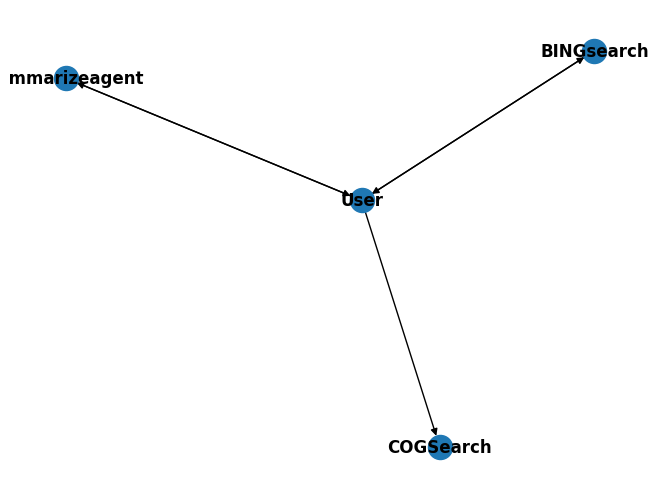

In [26]:
value = visualize_speaker_transitions_dict(allowed_speaker_transitions_dict_hub_and_spoke, agents)